# ****Importing Models****

In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,LSTM,Embedding,Conv1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import seaborn as sns
from scipy.special import softmax
from sklearn import preprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ****Training data review****

In [3]:
train_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/train.tsv', sep='\t')
train_data.head()

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,sentiment,feedback
0,30-Jul-18,02:16:00,5138527,Theresa Diaz,"2373 Long Mews\nSouth Lorraine, FL 83715",7445448464,Black Plus,Love my new Echo Plus,5,1
1,30-Jul-18,20:13:24,7881409,Michael Wagner,"34120 James Well Apt. 930\nSouth Kenneth, AK 5...",(202)233-6662,Configuration: Fire TV Stick,Works really well.,5,1
2,29-Jul-18,03:20:48,5658396,Erin Rodriguez,"7996 Booth Mission\nTaylorport, AL 13457",(219)882-0705,Black Show,Echo Show is said to work with certain apps bu...,2,0
3,30-Jul-18,22:48:21,4317957,Christine Perez,USS Schaefer\nFPO AA 86432,291-900-6087,Heather Gray Fabric,Very cool product. Speaker sounds good with my...,5,1
4,23-Jul-18,12:36:42,7570569,Jamie Davila,"000 Kevin Cliffs Suite 674\nBrennanview, NM 77690",9527296610,Black Plus,So far I love it. It was easy to set up - if ...,5,1


In [4]:
train_data.isnull().sum()

date                0
time                0
id                  0
reviewer name       0
reviewer address    0
contact number      0
variation           0
verified_reviews    1
sentiment           0
feedback            0
dtype: int64

In [5]:
train_data.fillna({"verified_reviews":"no review"}, inplace=True)

# ****Downloading RoBERTa transformer model****

In [6]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# ****Training Data preprocessing and feature engineering****

**Here we will make new dataframe where columns will be probability of each positive negative and neutral and their combined root mean square also binary representation of each of positive negative and neutral.The "VADER" sentiment analyzer will also be used as other feature in the data precprocessing.After that One hot encoded labels will be added for each in "variation" column of train data**

In [7]:
pov_review=[]
neg_review=[]
neu_review=[]
com_review=[]
vader_ratings=[]
pov_ratings=[]
neu_ratings=[]
neg_ratings=[]
sid_obj = SentimentIntensityAnalyzer()
for i in train_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        neg_review.append(scores[0])
        neu_review.append(scores[1])
        pov_review.append(scores[2])
        com_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        sentiment_dict = sid_obj.polarity_scores(i)
        vader_ratings.append(sentiment_dict['compound'])
        if max(scores)==scores[0]:
            neg_ratings.append(1.0)
            neu_ratings.append(0.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_ratings.append(0.0)
            neu_ratings.append(1.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_ratings.append(0.0)
            neu_ratings.append(0.0)
            pov_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_review.append(0.0)
        neg_review.append(0.0)
        neu_review.append(1.0)
        com_review.append(1.0)
        vader_ratings.append(1.0)
        neg_ratings.append(0.0)
        neu_ratings.append(1.0)
        pov_ratings.append(.0)

1
1


In [8]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(train_data[['variation']])
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['variation']))
one_hot_df.head()

,variation_Black,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
new_dataframe=pd.DataFrame({"positive":pov_review,"negative":neg_review,"neutral":neu_review,"combined":com_review,"feedback":list(map(lambda x: float(x),train_data['feedback'])),"isPositive":pov_ratings,"isNegative":neg_ratings,"isNeutral":neu_ratings ,"vader":vader_ratings})
new_dataframe = pd.concat([new_dataframe, one_hot_df], axis=1)
# new_dataframe.pop("vade")
new_dataframe.head()

,positive,negative,neutral,combined,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.880722,0.016766,0.102511,0.886827,1.0,1.0,0.0,0.0,0.6369,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.893248,0.027332,0.079420,0.897189,1.0,1.0,0.0,0.0,0.3384,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.057324,0.784362,0.158314,0.802230,0.0,0.0,1.0,0.0,0.9654,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.918911,0.009773,0.071316,0.921726,1.0,1.0,0.0,0.0,0.6697,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.917090,0.013619,0.069291,0.919804,1.0,1.0,0.0,0.0,0.9549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
new_dataframe.head()

,positive,negative,neutral,combined,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.880722,0.016766,0.102511,0.886827,1.0,1.0,0.0,0.0,0.6369,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.893248,0.027332,0.079420,0.897189,1.0,1.0,0.0,0.0,0.3384,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.057324,0.784362,0.158314,0.802230,0.0,0.0,1.0,0.0,0.9654,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.918911,0.009773,0.071316,0.921726,1.0,1.0,0.0,0.0,0.6697,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.917090,0.013619,0.069291,0.919804,1.0,1.0,0.0,0.0,0.9549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ****Data Visualization****

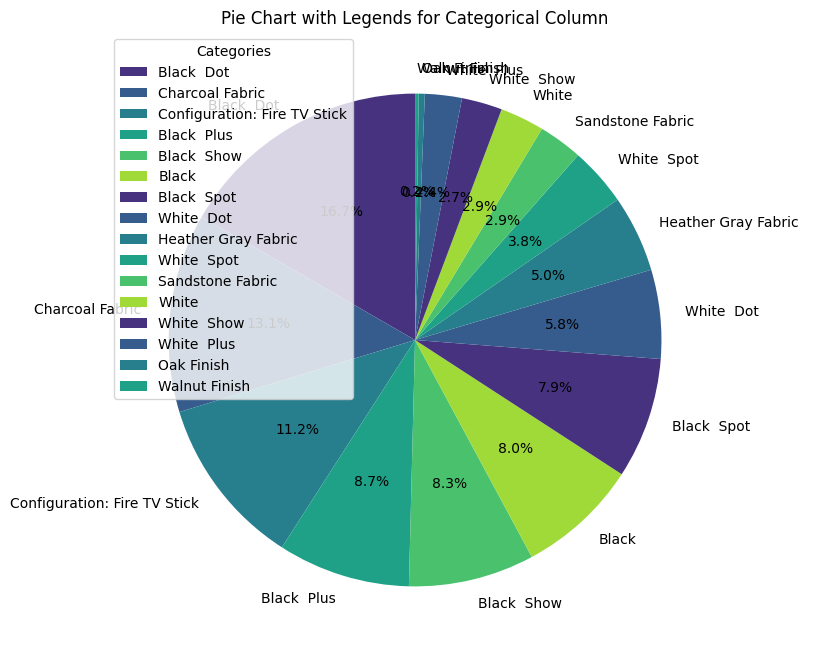

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(train_data['variation'].value_counts().values, labels=train_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=train_data['variation'].value_counts().index, loc='best')
plt.show()

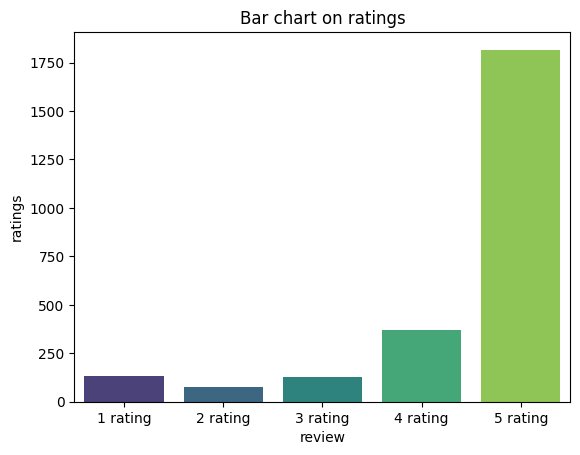

In [12]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in train_data['sentiment'] if i==1.0]),sum([1 for i in train_data['sentiment'] if i==2.0]),sum([1 for i in train_data['sentiment'] if i==3.0]),sum([1 for i in train_data['sentiment'] if i==4.0]),sum([1 for i in train_data['sentiment'] if i==5.0])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('Bar chart on ratings')
plt.show()

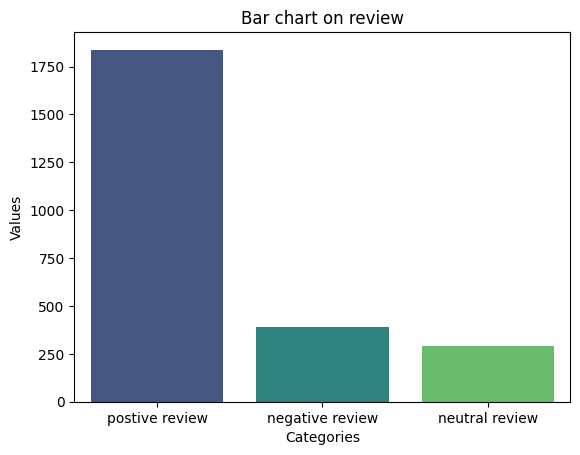

In [13]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_ratings),sum(neg_ratings),sum(neu_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart on review')
plt.show()

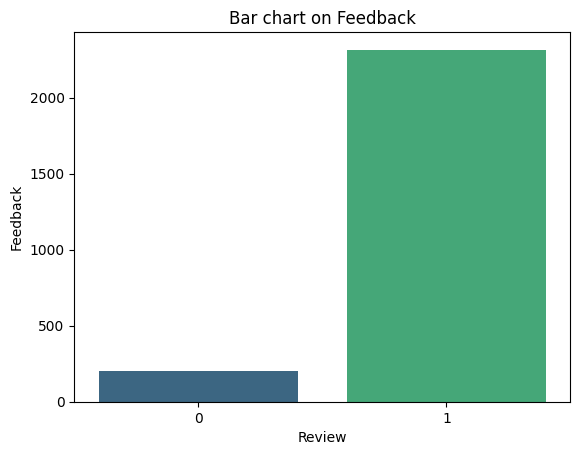

In [14]:
sns.barplot(x=["0","1"],y=[sum([1 for i in train_data['feedback'] if i==0.0]),sum([1 for i in train_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('Bar chart on Feedback')
plt.show()

# ****Training RandomForestClassifier on data featured out****

In [15]:
new_dataframe = preprocessing.StandardScaler().fit(new_dataframe).transform(new_dataframe.astype(float))
X_train, X_test, y_train, y_test = train_test_split(new_dataframe, train_data['sentiment'],  test_size=0.1,random_state=42 ) 
dtree_model = RandomForestClassifier(n_estimators=1000 ,random_state=5).fit(X_train, y_train)
dtree_predictions = dtree_model.score(X_test,y_test)
print(dtree_predictions)

0.8412698412698413


# ****Model Analysis****

The macro f1 score is 0.7149233900731429


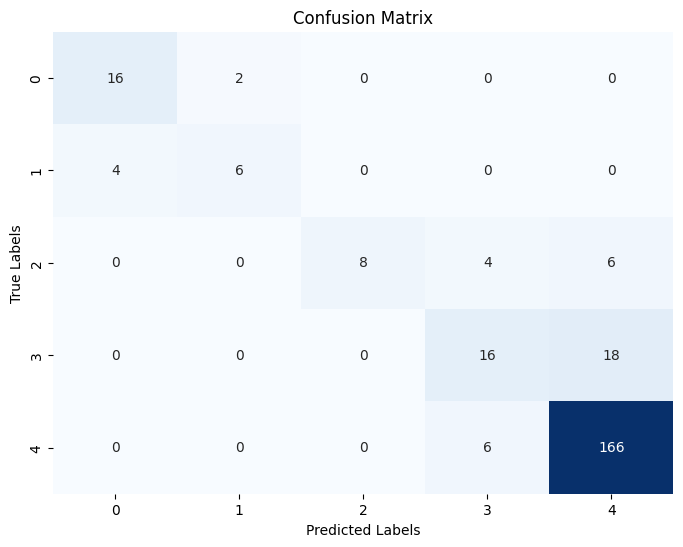

In [16]:
y_pred = dtree_model.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("The macro f1 score is "+str(macro_f1))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# print(str(y_pred))

# ****Test Data Review****

In [17]:
test_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/test.tsv', sep='\t')
test_data.head()

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,feedback
0,29-Jul-18,16:47:11,6074908,Russell Hensley,"9059 Morales Run Suite 912\nSouth Charles, MH ...",6932290613,Heather Gray Fabric,I have the original Alexa and the Tap and so f...,1
1,28-Jul-18,17:49:58,1159008,Adam Baxter,"13728 Jones Mission Apt. 526\nSouth Tylerfurt,...",385-994-9458,Black Plus,Great product. More skills are needed. I love it.,1
2,30-Jul-18,16:46:29,1759753,Sarah Contreras,"7113 Pratt Plains\nPalmermouth, IN 02370",(738)354-8387,Configuration: Fire TV Stick,I will never buy anything Amazon makes again!T...,0
3,29-Jul-18,19:23:32,1861422,Tim Castillo,"93586 Cook Union Apt. 080\nMorganmouth, WI 51175",(294)877-6223,Black Plus,Not perfect but very good! A few times Alexa p...,1
4,28-Jul-18,16:15:25,3116018,Barry Young,69809 Harrington Meadows Apt. 256\nLake Courtn...,262-863-1391,Black Show,Kids like it for games. Showing the lyrics fo...,1


In [18]:
train_data.isnull().sum()

date                0
time                0
id                  0
reviewer name       0
reviewer address    0
contact number      0
variation           0
verified_reviews    0
sentiment           0
feedback            0
dtype: int64

# ****Testing Data preprocessing and feature engineering****

**the same logic that we applied on feature engineering of train data will be applied here**

In [19]:
pov_test_review=[]
neg_test_review=[]
neu_test_review=[]
com_test_review=[]
neg_test_ratings=[]
neu_test_ratings=[]
pov_test_ratings=[]
vader_test_ratings=[]
for i in test_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        neg_test_review.append(scores[0])
        neu_test_review.append(scores[1])
        pov_test_review.append(scores[2])
        com_test_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        sentiment_dict = sid_obj.polarity_scores(i)
        vader_test_ratings.append(sentiment_dict['compound'])
        if max(scores)==scores[0]:
            neg_test_ratings.append(1.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(1.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_test_review.append(1.0)
        neg_test_review.append(0.0)
        neu_test_review.append(0.0)
        com_test_review.append(1.0)
        neg_test_ratings.append(0.0)
        neu_test_ratings.append(0.0)
        pov_test_ratings.append(1.0)

In [20]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(test_data[['variation']])
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['variation']))
one_hot_df.head()

,variation_Black,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
test_dataframe=pd.DataFrame({"positive":pov_test_review,"negative":neg_test_review,"neutral":neu_test_review,"combined":com_test_review,"feedback":list(map(lambda x: float(x),test_data['feedback'])),"isPositive":pov_test_ratings,"isNegative":neg_test_ratings,"isNeutral":neu_test_ratings,"vader":vader_test_ratings},columns=['positive','negative','neutral','combined','feedback','isPositive', 'isNegative', 'isNeutral','vader'])
test_dataframe = pd.concat([test_dataframe, one_hot_df], axis=1)
# test_dataframe.pop("vader")
test_dataframe.head()

,positive,negative,neutral,combined,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.859859,0.053545,0.086596,0.865866,1.0,1.0,0.0,0.0,0.9802,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.937681,0.015595,0.046725,0.938974,1.0,1.0,0.0,0.0,0.8519,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011588,0.956889,0.031523,0.957478,0.0,0.0,1.0,0.0,-0.7507,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.306549,0.353358,0.340093,0.578357,1.0,0.0,1.0,0.0,0.9741,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.795684,0.029179,0.175137,0.815253,1.0,1.0,0.0,0.0,0.6705,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
test_dataframe = preprocessing.StandardScaler().fit(test_dataframe).transform(test_dataframe.astype(float))

# ****Running Model on test data**** 

In [23]:
arr=dtree_model.predict(test_dataframe)
print(arr)

[5 5 2 5 5 5 5 5 1 3 5 5 5 5 5 5 1 5 3 4 5 5 5 5 5 5 1 5 5 1 5 5 5 5 5 5 5
 5 5 5 5 1 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 1 5 5 5 5 1 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 3 1 5 2 5 4 5 5 4 5
 5 1 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 3 5 5 4 4 5 5 5 5 5 1 5 5 3 4 5 5 5 5 5 4 5 5 5 5 4 5 5 1 5 5 5 5 5 2 5
 2 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 5 5 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 1 5 5 5 4 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 4 5 5 4 5 1 5 5
 5 5 3 5 5 5 5 5 5 5 5 5 4 5 2 5 5 5 5 4 5 5 5 3 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 3 5 1 5 3 5 5 4 5 5 5 5 5 5 5 5 5 5 3 5 5 5
 5 5 5 5 5 5 5 5 5 1 5 3 5 5 5 5 5 1 5 5 5 5 5 1 5 5 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 1 5 5 5 5 5 1 5 5 5 5 5 5 1 1 3 5 5 5 5 1 5 5 5 1 5 4 5 4 5 5 5 5
 5 5 5 5 4 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 2 3 5
 5 5 5 5 5 1 5 5 5 1 5 5 3 5 5 5 5 5 5 3 5 5 1 5 5 4 5 5 5 5 5 4 1 5 5 5 5
 5 5 5 3 5 5 5 5 5 1 4 5 

# ****Test data and Result Visualization****

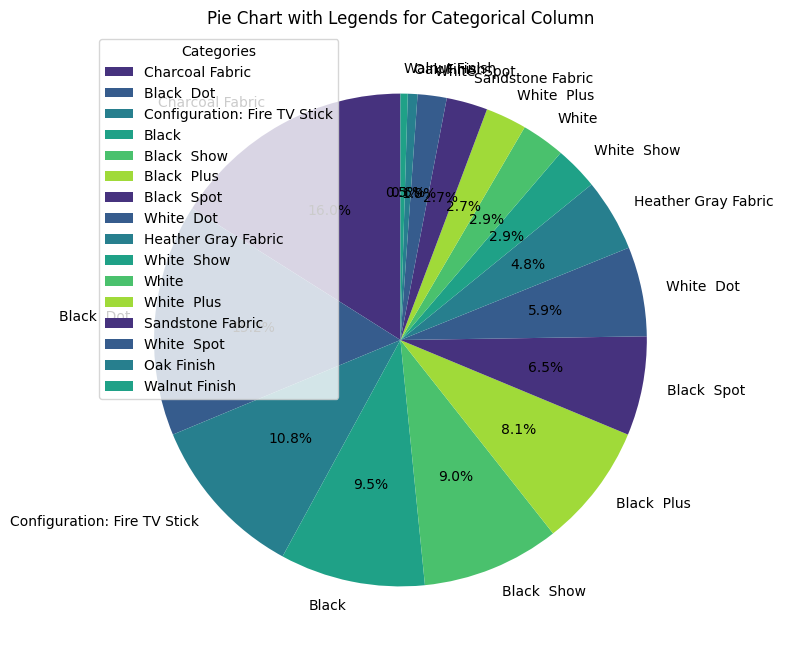

In [24]:
plt.figure(figsize=(8, 8))
plt.pie(test_data['variation'].value_counts().values, labels=test_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=test_data['variation'].value_counts().index, loc='best')
plt.show()

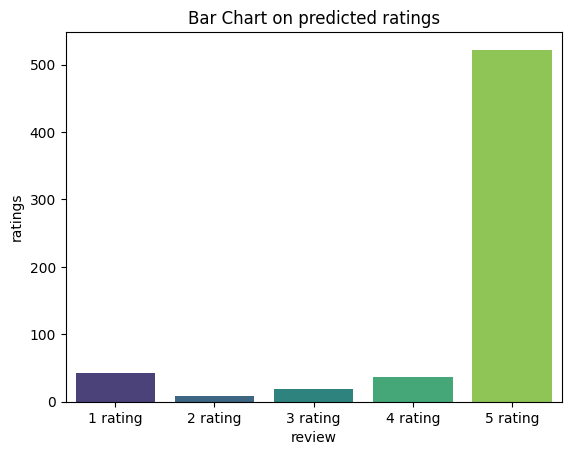

In [25]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in arr if i==1]),sum([1 for i in arr if i==2]),sum([1 for i in arr if i==3]),sum([1 for i in arr if i==4]),sum([1 for i in arr if i==5])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('Bar Chart on predicted ratings')
plt.show()

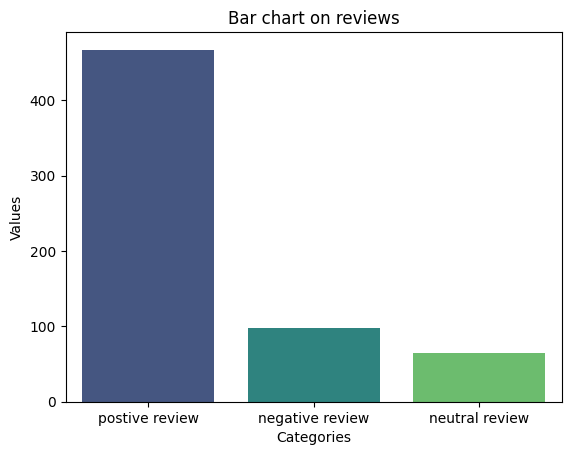

In [26]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_test_ratings),sum(neg_test_ratings),sum(neu_test_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart on reviews')
plt.show()

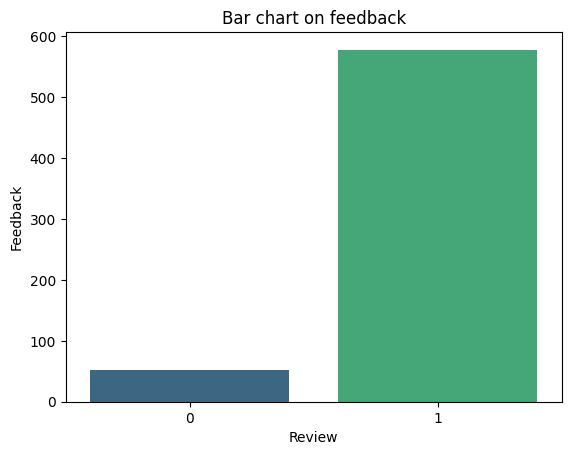

In [27]:
sns.barplot(x=["0","1"],y=[sum([1 for i in test_data['feedback'] if i==0.0]),sum([1 for i in test_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('Bar chart on feedback')
plt.show()

# ****Downloading the CSV file****

In [28]:
submission=pd.DataFrame({"id":test_data['id'],"sentiment":arr})
submission.to_csv("submission.csv",index=False)